# MDI 720 : Statistiques
## CategoricalVariables
### *Joseph Salmon*

This notebook reproduces the pictures for the course "CategoricalVariables_fr"

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn import linear_model
import seaborn as sns
from os import mkdir, path, getcwd
from sklearn import preprocessing
from random import shuffle, seed
import matplotlib.animation as animation
from statsmodels.nonparametric.kde import KDEUnivariate
%matplotlib notebook
from IPython.display import HTML
from urllib.request import urlretrieve
from requests import get

/home/jo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Plot initialization

In [2]:
dirname = "../srcimages/"
if not path.exists(dirname):
    mkdir(dirname)

imageformat = '.pdf'
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.axes_style()
sns.set_style({'legend.frameon': True})
color_blind_list = sns.color_palette("colorblind", 8)
my_orange = color_blind_list[2]
my_green = color_blind_list[1]
my_blue = color_blind_list[0]

plt.close("all")

# Data description: cps09mar

The Current Population Survey (CPS) is a monthly survey of about 57,000 U.S. households conducted 
by the Bureau of the Census of the Bureau of Labor Statistics. The CPS is the primary source of 
information on the labor force characteristics of the U.S. population. The survey covers employment, 
earnings, educational attainment, income, poverty, health insurance coverage, job experience, voting 
and registration, computer usage, veteran status, and other variables.

Details can be found at  https://www.census.gov/programs-surveys/cps.html and https://dataferrett.census.gov/

From the March 2009 survey we extracted the individuals with non-allocated variables who were full-time
employed (defined as those who had worked at least 36 hours per week for at least 48 weeks the  past year),
and excluded those in the military. This sample has 50,742 individuals. We extracted 12 
variables from the CPS on these individuals. 

1. age: years, capped at 85
2. female: 1 Female, 0 otherwise
3. hisp:  1 if Spanish, Hispanic, or Latino, 0 otherwise
4. education:
    - 0 : Less than 1st grade
    - 4 : 1st, 2nd, 3rd, or 4th grade
    - 6 : 5th or 6 th grade
    - 8 : 7th or 8 th grade
    - 9 : 9th grade
    - 10: 10th grade
    - 11: 11th grade or 12th grade with no high school diploma
    - 12: High school graduate, high school diploma or equivalent
    - 13: Some college but no degree 
    - 14: Associate degree in college, including occupation/vocation programs
    - 16: Bachelor's degree or equivalent (BA, AB, BS)
    - 18: Master’s degree (MA, MS, MENG, MED, MSW, MBA)
    - 20: Professional degree or Doctorate degree (MD, DDS, DVM, LLB, JD, PHD, EDD)

5. earnings: total annual wage and salary earnings
6. hours: number of hours worked per week
7. week:  number of weeks worked per year
8. union: 1 for member of a labor union, 0 otherwise
9. uncov: 1 if covered by a union or employee association contract, 0 otherwise
10. region:
    - 1 : Northeast
    - 2 : Midwest
    - 3 : South
    - 4 : West
11. Race:
    - 1 : White only
    - 2 : Black only
    - 3 : American Indian, Alaskan Native (AI) only
    - 4 : Asian only
    - 5 : Hawaiian/Pacific Islander (HP) only
    - 6 : White-Black
    - 7 : White-AI   
    - 8 : White-Asian
    - 9 : White-HP
    - 10: Black-AI   
    - 11: Black-Asian
    - 12: Black-HP
    - 13: AI-Asian
    - 14: Asian-HP
    - 15: White-Black-AI   
    - 16: White-Black-Asian
    - 17: White-AI-Asian
    - 18: White-Asian-HP
    - 19: White-Black-AI-Asian
    - 20: 2 or 3 races
    - 21: 4 or 5 races
12. marital:
    - 1 : Married - civilian spouse present
    - 2 : Married - Armed Forces spouse present
    - 3 : Married - spouse absent (except separated)
    - 4 : Widowed
    - 5 : Divorced
    - 6 : Separated
    - 7 : Never married

# Loading data:


In [3]:
# information on dataset:
# https://www.ssc.wisc.edu/~bhansen/econometrics/cps09marReadMe.pdf
URL = 'https://www.ssc.wisc.edu/~bhansen/econometrics/'


def get_cps09mar_data(url=URL, filename='cps09mar.txt'):
    URL_full = URL + filename
    target_path = getcwd() +'/' + filename  # your local directory
    if not path.exists(filename):
        response = get(URL_full, stream=True)
        handle = open(target_path, "wb")
        for chunk in response.iter_content(chunk_size=512):
            if chunk:  # filter out keep-alive new chunks
                handle.write(chunk)      
    u_cols = ['age', 'female', 'hisp', 'education', 'earnings', 'hours',
              'week', 'union', 'uncov', 'region', 'race', 'marital']
    data = pd.read_csv('cps09mar.txt', sep=r"\s+",
                       names=u_cols, na_values='NA', dtype=np.float64)
    return data


data = get_cps09mar_data(url=URL, filename='cps09mar.txt')

# Descriptive statistics

In [4]:
# To get correct display format
pd.options.display.float_format = '{:,.3f}'.format

# for this dataset na_values are marked as NA.
n_samples_ini = data.shape[0]
print("The original dataset has {} samples and {} features".format(
    data.shape[0], data.shape[1]))

# Remove NA:
data = data.dropna(axis=0, how='any')
data.head()

The original dataset has 50687 samples and 12 features


,age,female,hisp,education,earnings,hours,week,union,uncov,region,race,marital
0,52.000,0.000,0.000,12.000,"146,000.000",45.000,52.000,0.000,0.000,1.000,1.000,1.000
1,38.000,0.000,0.000,18.000,"50,000.000",45.000,52.000,0.000,0.000,1.000,1.000,1.000
2,38.000,0.000,0.000,14.000,"32,000.000",40.000,51.000,0.000,0.000,1.000,1.000,1.000
3,41.000,1.000,0.000,13.000,"47,000.000",40.000,52.000,0.000,0.000,1.000,1.000,1.000
4,42.000,0.000,0.000,13.000,"161,525.000",50.000,52.000,1.000,0.000,1.000,1.000,1.000


In [5]:
# TODO : XXX Figure 2.1: Wage Distribution and Density. All full-time U.S. workers

In [6]:
# Adding log-hourwage
y = np.log(data['earnings'] / (data['hours'] * data['week']))
print(y.shape)
data['log-hourwage'] = y

# If high education needed:
# data['high-education'] = (data['education']> 9).astype(float)
data.head()

(50686,)


,age,female,hisp,education,earnings,hours,week,union,uncov,region,race,marital,log-hourwage
0,52.000,0.000,0.000,12.000,"146,000.000",45.000,52.000,0.000,0.000,1.000,1.000,1.000,4.133
1,38.000,0.000,0.000,18.000,"50,000.000",45.000,52.000,0.000,0.000,1.000,1.000,1.000,3.062
2,38.000,0.000,0.000,14.000,"32,000.000",40.000,51.000,0.000,0.000,1.000,1.000,1.000,2.753
3,41.000,1.000,0.000,13.000,"47,000.000",40.000,52.000,0.000,0.000,1.000,1.000,1.000,3.118
4,42.000,0.000,0.000,13.000,"161,525.000",50.000,52.000,1.000,0.000,1.000,1.000,1.000,4.129


In [7]:
male = data['female'] == 0.
female = data['female'] == 1.

n_male = np.sum(male)
n_female = np.sum(female)
print("In the dataset, there are: \n n_male   = {} male \n n_female = {} female.".format(
    n_male, n_female))

In the dataset, there are: 
 n_male   = 29111 male 
 n_female = 21575 female.


In [8]:
print(data['education'].min())
print(data['education'].max())

0.0
20.0


<IPython.core.display.Javascript object>


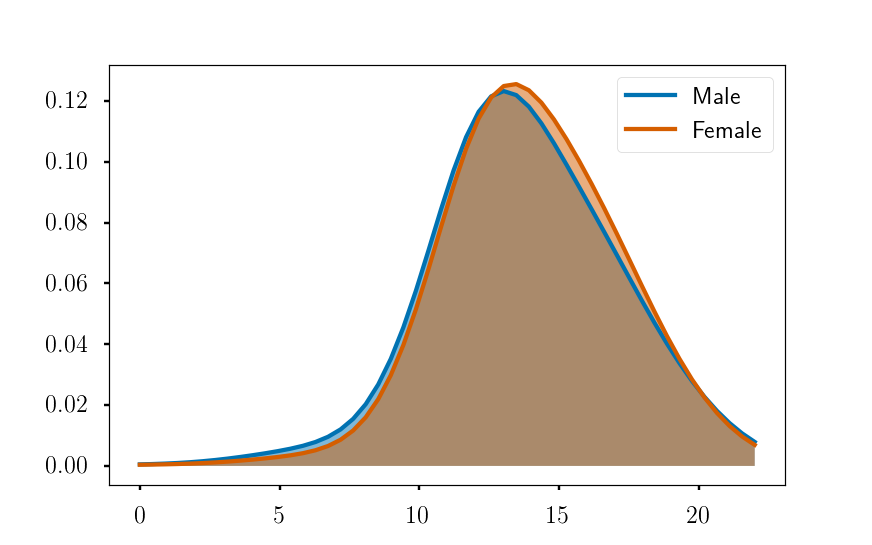

In [9]:
xgrid = np.linspace(data['education'].min() * 0.9,
                    data['education'].max() * 1.1)

fig1 = plt.figure(figsize=(8, 5))
kde_male = KDEUnivariate(data['education'][male])
kde_male.fit(bw=2, kernel='gau')
pdf_est_male = kde_male.evaluate(xgrid)
plt.plot(xgrid, pdf_est_male, color=my_blue, label='Male')
plt.fill_between(xgrid, 0, pdf_est_male, facecolor=my_blue, alpha=0.5)

kde_female = KDEUnivariate(data['education'][female])
kde_female.fit(bw=2, kernel='gau')
pdf_est_female = kde_female.evaluate(xgrid)
plt.plot(xgrid, pdf_est_female, color=my_orange, label='Female',)
plt.fill_between(xgrid, 0, pdf_est_female, facecolor=my_orange, alpha=0.5)

plt.legend()

# 1D regression: log(wage) vs. education
Here we apply a simpel 1D OLS method with intercept to the explain the log(wage) w.r.t. eduction (the number of education year.

<IPython.core.display.Javascript object>


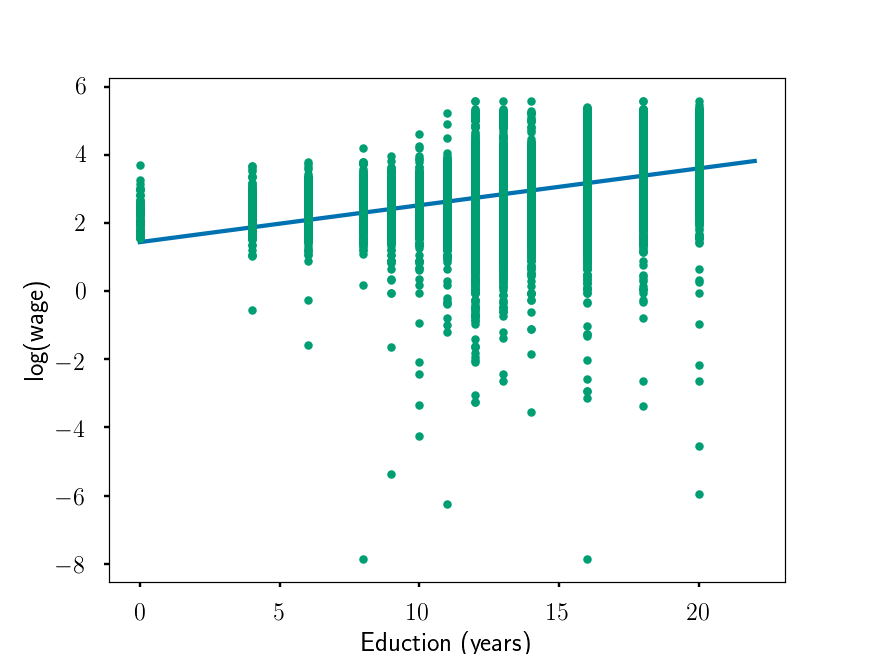

In [10]:
skl_lm = linear_model.LinearRegression(fit_intercept=True)
X_uni = data['education'].values.reshape(-1, 1)
skl_lm.fit(X_uni, y)
plt.figure()
plt.plot(xgrid.reshape(-1, 1), skl_lm.predict(xgrid.reshape(-1, 1)))
plt.plot(X_uni, y, '.')
plt.xlabel('Eduction (years)')
plt.ylabel('log(wage)')

<IPython.core.display.Javascript object>


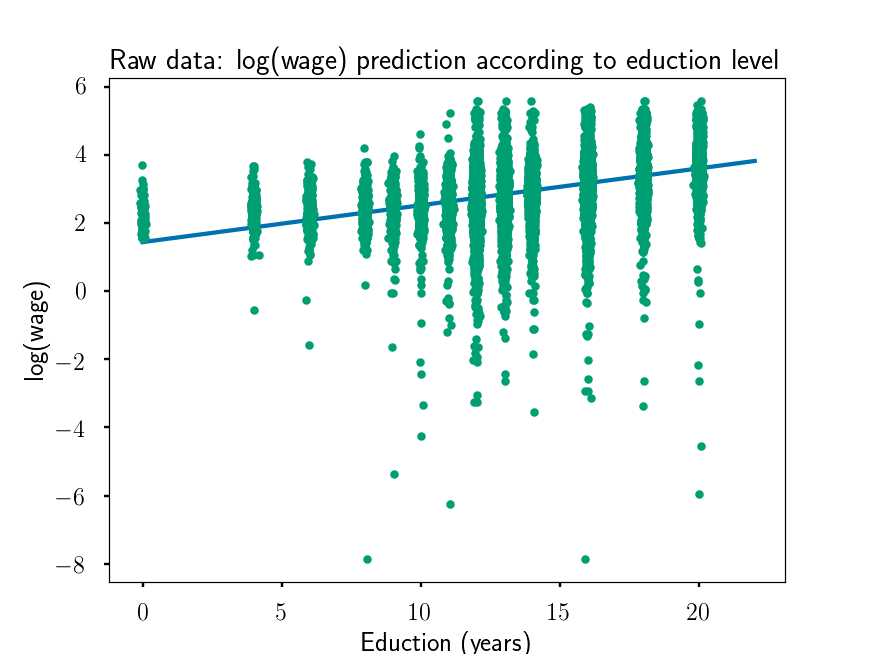

In [11]:
# Improved visualisation using jittering:
jitter = 0.05  # to avoid overlap
plt.figure()
plt.plot(xgrid.reshape(-1, 1), skl_lm.predict(xgrid.reshape(-1, 1)))
plt.plot(X_uni.squeeze() + jitter * np.random.randn(X_uni.shape[0]), y, '.')
plt.xlabel('Eduction (years)')
plt.ylabel('log(wage)')
plt.title('Raw data: log(wage) prediction according to eduction level')

# A simplified visualisation for the same numerical variable:
the observation are average (groupby) according to the number of education years. 

In [12]:
y_reduced = data['log-hourwage'].groupby(data['education']).mean().values
x_reduced = np.sort(data['education'].unique()).reshape(-1, 1)
n_education = x_reduced.shape[0]

<IPython.core.display.Javascript object>


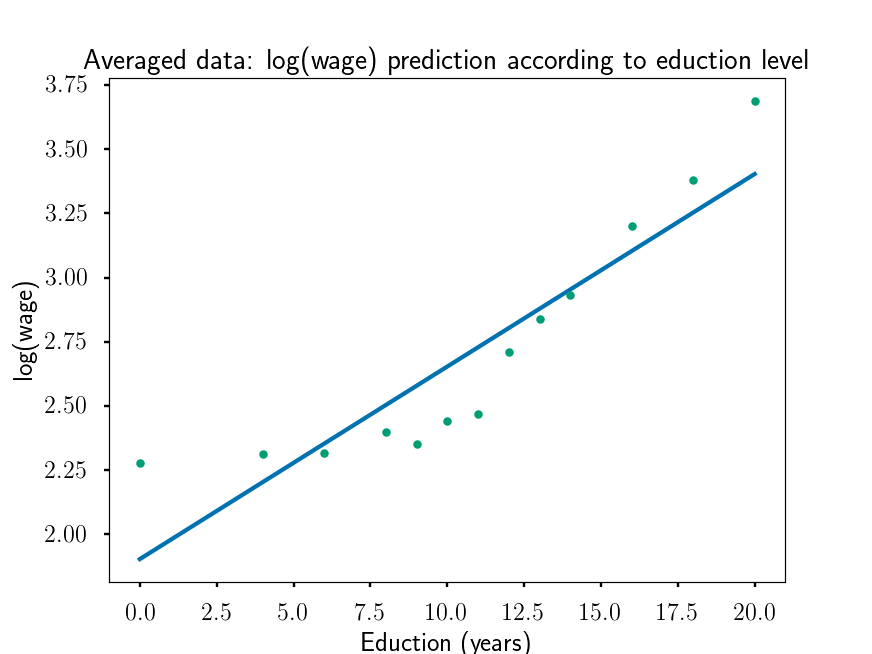

In [13]:
y_pred_reduced = skl_lm.fit(x_reduced, y_reduced).predict(x_reduced)
plt.figure()
plt.plot(x_reduced, y_pred_reduced)
plt.plot(x_reduced, y_reduced, '.')
plt.xlabel('Eduction (years)')
plt.ylabel('log(wage)')
plt.title('Averaged data: log(wage) prediction according to eduction level')

#  OLS: log(wage) vs. genre, 1 categorical variable only

(50686, 1)


<IPython.core.display.Javascript object>


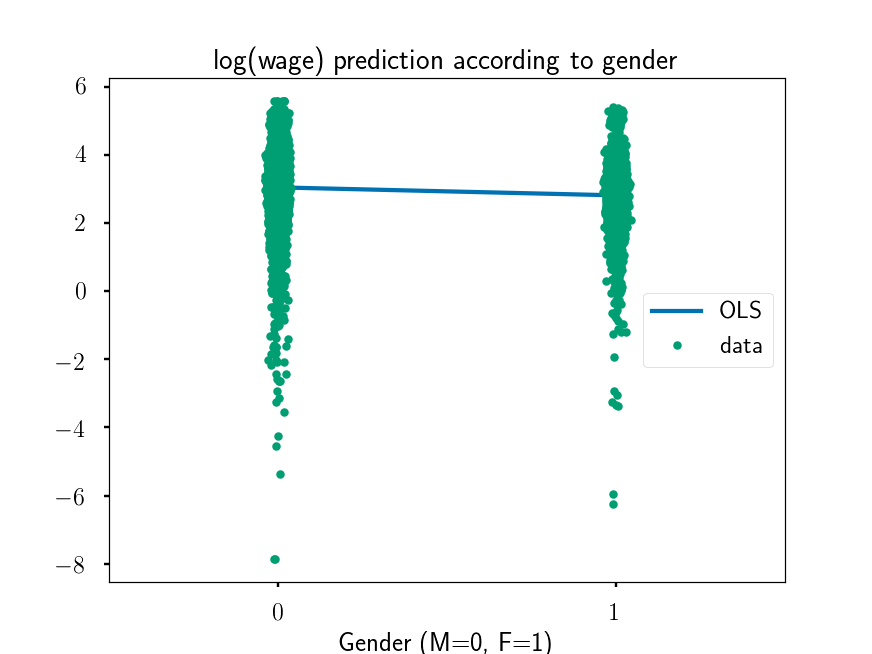

In [42]:
skl_lm = linear_model.LinearRegression(fit_intercept=True)
X_uni = data.copy()['female'].values.reshape(-1, 1)
print(X_uni.shape)
skl_lm.fit(X_uni, y)
jitter = 0.01
plt.figure()
xgrid_bin = np.array([0, 1])
plt.plot(xgrid_bin.reshape(-1, 1), skl_lm.predict(xgrid_bin.reshape(-1, 1)), label="OLS")
plt.plot(X_uni + jitter * np.random.randn(X_uni.shape[0]).reshape(-1, 1) , y, '.', label="data")
plt.xlim(-0.5, 1.5)
plt.xticks([0, 1])
plt.xlabel('Gender (M=0, F=1)')
plt.title("log(wage) prediction according to gender")
plt.legend(loc=5)

In [15]:
print("Average log(wage):\
      \n for a male  it is   {:0.4}\
      \n for a female it is {:0.4}".format(
    skl_lm.predict(xgrid_bin[0])[0], skl_lm.predict(xgrid_bin[1])[0]))

Average log(wage):      
 for a male  it is   3.046      
 for a female it is 2.812


#  OLS: log(wage) vs. (education+genre), 1 categorical + 1 numerical  
$$ log(wage) \approx \theta_0 + \theta_1 education + \theta_2 female$$

<IPython.core.display.Javascript object>


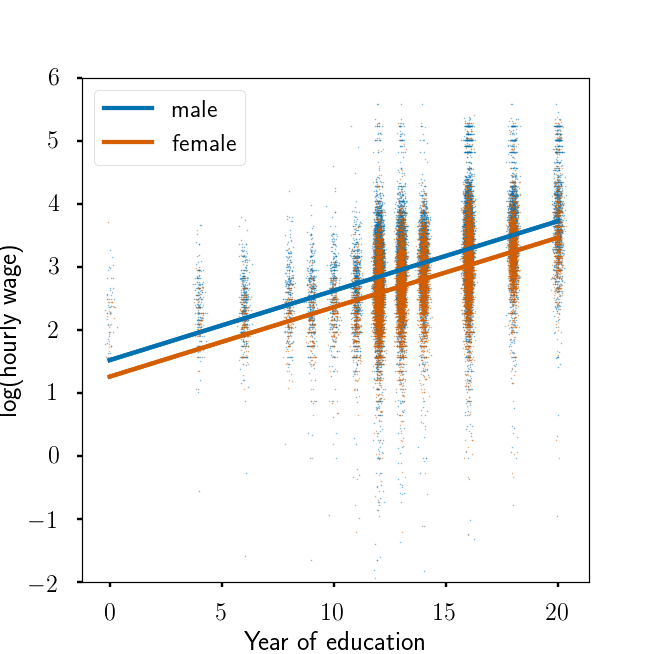

In [16]:
skl_lm = linear_model.LinearRegression(fit_intercept=True)
X_uni = data.copy()[['education', 'female']]
skl_lm.fit(X_uni, y)

X_to_predic_male = np.concatenate(
    [x_reduced, np.zeros([n_education, 1])], axis=1)
X_to_predic_female = np.concatenate(
    [x_reduced, np.ones([n_education, 1])], axis=1)


plt.figure(figsize=(6, 6))
ylims = [-2., 6.]
plt.plot(x_reduced, skl_lm.predict(X_to_predic_male), label='male', c=my_blue)
plt.plot(x_reduced, skl_lm.predict(
    X_to_predic_female), label='female', c=my_orange)

jitter = 0.1  # to avoid overlap
plt.plot(data['education'][male] + jitter *
         np.random.randn(n_male), y[male], '.', c=my_blue, ms=2, alpha=0.5)
plt.plot(data['education'][female] + jitter *
         np.random.randn(n_female), y[female], '.', c=my_orange, ms=2, alpha=0.5)

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ylims[0], ylims[1]))

# checking the lines equations are correct:
plt.plot(x_reduced, skl_lm.intercept_ + x_reduced * skl_lm.coef_[0], c=my_blue)
plt.plot(x_reduced, skl_lm.intercept_ +
         skl_lm.coef_[1] + x_reduced * skl_lm.coef_[0], c=my_orange)

plt.xlabel('Year of education')
plt.ylabel('log(hourly wage)')
plt.legend()

***Conclusion***: adding a categorical variable "female" allows to have a different intercept for the two population (Male and Female). Note that we made the choice to use only "female" for that. This is checked as the lines displayed:

- Male line  : $ log(wage) \approx \theta_0 + \theta_1 education $
- Female line: $ log(wage) \approx \theta_0 + \theta_2 + \theta_1 education $

are identical to the prediction given by the model. We can check that in the US population male are expected to have a higher wage.

#  OLS: log(wage) vs. (education+genre), 2 categorical + 1 numerical  
$$ log(wage) \approx \theta_0 + \theta_1 education + \theta_2 female + \theta_3 married$$

<IPython.core.display.Javascript object>


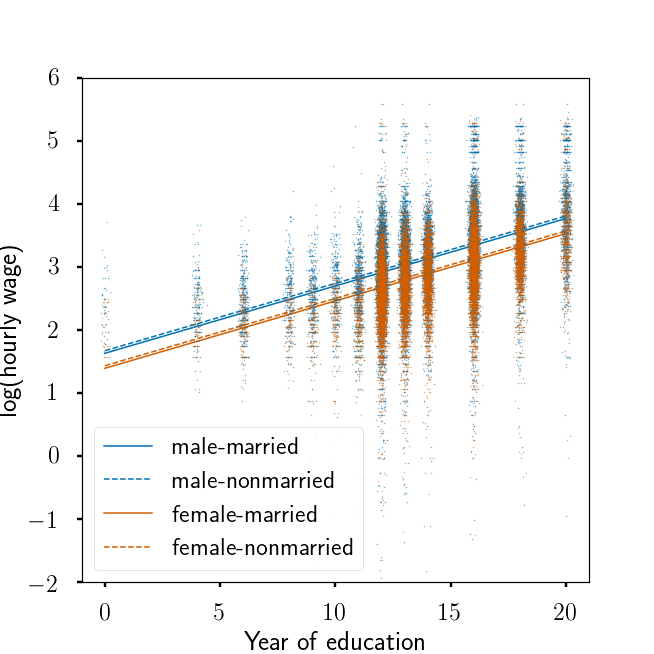

[ 0.10696936 -0.23835611 -0.04095222]


In [17]:
skl_lm = linear_model.LinearRegression(fit_intercept=True)
X_uni = data.copy()[['education', 'female', 'marital']]
married = X_uni['marital'] == 1
n_married = np.sum(married)
skl_lm.fit(X_uni, y)

X_to_predic_male_married = np.concatenate(
    [x_reduced, np.zeros([n_education, 1]), np.ones([n_education, 1])], axis=1)
X_to_predic_male_nonmarried = np.concatenate(
    [x_reduced, np.zeros([n_education, 1]), np.zeros([n_education, 1])], axis=1)
X_to_predic_female_married = np.concatenate(
    [x_reduced, np.ones([n_education, 1]), np.ones([n_education, 1])], axis=1)
X_to_predic_female_nonmarried = np.concatenate(
    [x_reduced, np.ones([n_education, 1]), np.zeros([n_education, 1])], axis=1)

plt.figure(figsize=(6, 6))
plt.plot(x_reduced, skl_lm.predict(X_to_predic_male_married),
         '-', lw=1, label='male-married', c=my_blue)
plt.plot(x_reduced, skl_lm.predict(X_to_predic_male_nonmarried),
         '--', lw=1, label='male-nonmarried', c=my_blue)
plt.plot(x_reduced, skl_lm.predict(X_to_predic_female_married),
         '-', lw=1, label='female-married', c=my_orange)
plt.plot(x_reduced, skl_lm.predict(X_to_predic_female_nonmarried),
         '--', lw=1, label='female-nonmarried', c=my_orange)

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ylims[0], ylims[1]))

jitter = 0.1  # to avoid overlap
plt.plot(data['education'][male] + jitter *
         np.random.randn(n_male), y[male], '.', c=my_blue, ms=2, alpha=0.5)
plt.plot(data['education'][female] + jitter *
         np.random.randn(n_female), y[female], '.', c=my_orange, ms=2, alpha=0.5)

plt.xlabel('Year of education')
plt.ylabel('log(hourly wage)')
plt.legend()

print(skl_lm.coef_)

This is equivalent to:

$$ log(wage) \approx \mu_{0,0} + \theta_1 education + \mu_{1,0} married \cdot male + \mu_{1,1} married \cdot female$$

with:

- $\mu_{0,0}$ represents non-married male
- $\mu_{0,1}$ represents married male
- $\mu_{1,0}$ represents non-married female
- $\mu_{1,1}$ represents married female

and the linkes:

- $\mu_{0,0} = \theta_0 $
- $\mu_{0,1} = \theta_0 + \theta_3 $
- $\mu_{1,0} = \theta_0 + \theta_2 $
- $\mu_{1,1} = \theta_0 + \theta_2 + \theta_3 $

In [18]:
theta0 = skl_lm.intercept_
theta1 = skl_lm.coef_[0]
theta2 = skl_lm.coef_[1]
theta3 = skl_lm.coef_[2]
print(' theta0 = {:.4}\n theta1 = {:.4}\n theta2 = {:.4}\n theta3 = {:.4}'.format(
    theta0, theta1, theta2, theta3))

 theta0 = 1.671
 theta1 = 0.107
 theta2 = -0.2384
 theta3 = -0.04095


In [19]:
mu00 = theta0
mu01 = theta0 + theta3
mu10 = theta0 + theta2
mu11 = theta0 + theta2 + theta3

In [20]:
print(' mu00 = {:.4} (non-married male)\
     \n mu01 = {:.4} (married male)\
     \n mu10 = {:.4} (non-married female)\
     \n mu11 = {:.4} (married female)'.format(
    mu00, mu01, mu10, mu11))

 mu00 = 1.671 (non-married male)     
 mu01 = 1.63 (married male)     
 mu10 = 1.433 (non-married female)     
 mu11 = 1.392 (married female)


***Conclusion***: we can check that the influence of being married is correlated with a lower salary (XXX: more is needed to understand this point here...)

# Adding one feature: create a categorical variable "the education level is smaller than 9 years" (low_edu) and see its influence on eduction.
$$ log(wage) \approx \theta_0 + \theta_1 education + \theta_2 eduction * \cdot lowedu$$

In [21]:
x_low_edu = (x_reduced < 9).astype(float)
X = np.concatenate([x_reduced, (x_reduced - 9) * (x_low_edu)], axis=1)
skl_lm = linear_model.LinearRegression(fit_intercept=True)
skl_lm.fit(X, y_reduced)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<IPython.core.display.Javascript object>


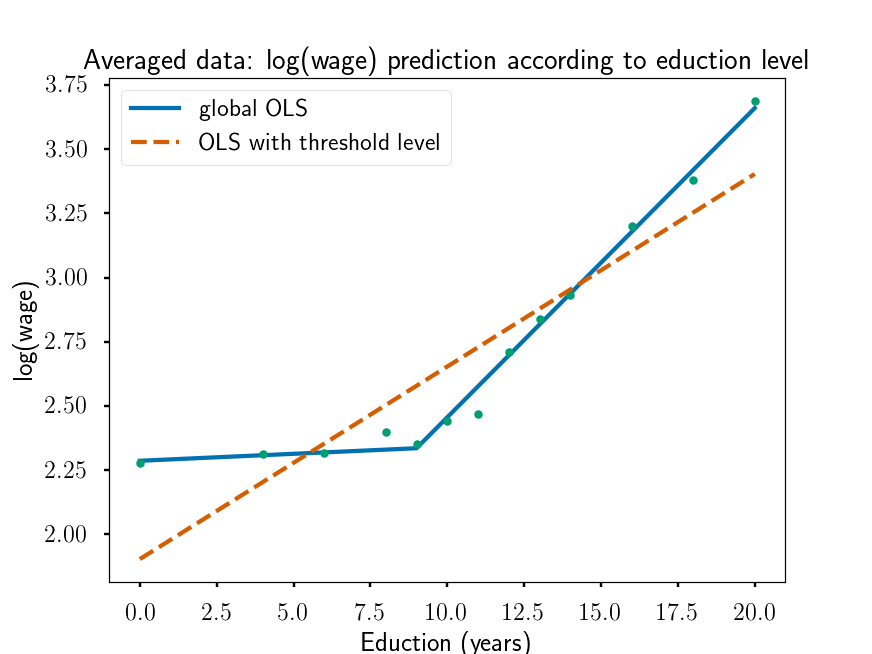

In [22]:
plt.figure()
plt.plot(x_reduced, skl_lm.predict(X), label="global OLS")
plt.plot(x_reduced, y_reduced, '.')
plt.plot(x_reduced, y_pred_reduced, '--', label="OLS with threshold level")
plt.xlabel('Eduction (years)')
plt.ylabel('log(wage)')
plt.title('Averaged data: log(wage) prediction according to eduction level')
plt.legend()

In [23]:
skl_lm = linear_model.LinearRegression(fit_intercept=True)
scores = np.zeros(n_education)
for i, val in enumerate(x_reduced.squeeze()):
    x_low_edu_loop = (x_reduced < val).astype(float)
    X = np.concatenate([x_reduced, (x_reduced - val)
                        * (x_low_edu_loop)], axis=1)
    skl_lm.fit(X, y_reduced)
    scores[i] = skl_lm.score(X, y_reduced)
print('Best choice (for R^2 score) on training part was to choose a kink at {}.'.format(
    x_reduced[scores.argmax()][0]))

Best choice (for R^2 score) on training part was to choose a kink at 10.0.


# Adding one feature: use eduction, lowedu and female.
$$ log(wage) \approx \theta_0 + \theta_1 education + \theta_2 eduction * \cdot lowedu + \theta_3 female$$

In [24]:
# some help for groupby: http://wesmckinney.com/blog/groupby-fu-improvements-in-grouping-and-aggregating-data-in-pandas/
tab = data['log-hourwage'].groupby([data['education'], data['female']]).mean()
y_reduced_female = tab.values[1::2]
y_reduced_male = tab.values[::2]

X = np.concatenate([x_reduced, (x_reduced - 9) * (x_low_edu)], axis=1)
skl_lm_female = linear_model.LinearRegression(fit_intercept=True)
skl_lm_female.fit(X, y_reduced_female)

skl_lm_male = linear_model.LinearRegression(fit_intercept=True)
skl_lm_male.fit(X, y_reduced_male)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<IPython.core.display.Javascript object>


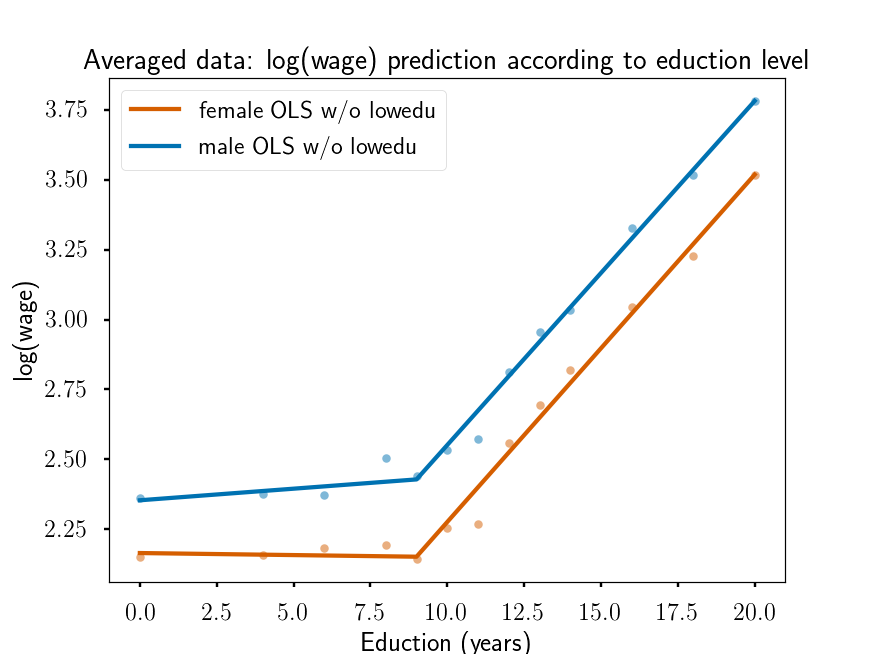

In [25]:
plt.figure()
plt.plot(x_reduced, skl_lm_female.predict(X), label="female OLS w/o lowedu", c=my_orange)
plt.plot(x_reduced, skl_lm_male.predict(X), label="male OLS w/o lowedu", c=my_blue)
plt.plot(x_reduced, y_reduced_female, '.', c=my_orange, alpha=0.5)
plt.plot(x_reduced, y_reduced_male, '.', c=my_blue, alpha=0.5)

# plt.plot(x_reduced, y_pred_reduced,'--',label="OLS with threshold level")
plt.xlabel('Eduction (years)')
plt.ylabel('log(wage)')
plt.title('Averaged data: log(wage) prediction according to eduction level')
plt.legend()